## 1. Import Library

In [21]:
# Basic Library
import pandas as pd
import numpy as np
import os

# Preprocessing
from sklearn.preprocessing import OneHotEncoder

# HP Tuning
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour, plot_optimization_history
from optuna.visualization import plot_parallel_coordinate, plot_slice, plot_param_importances

# Modeling
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, log_loss
from lightgbm import LGBMClassifier
import tensorflow as tf
import keras
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## 2. Import Data

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
submission = pd.read_csv("data/sample_submission.csv")

## 3. LightGBM Modeling

### (1) HP Tuning

In [3]:
train_x = train.iloc[:, 1:-1]
train_y = train.iloc[:, -1:]
test_x = test.iloc[:, 1:]

In [4]:
def lgb_objective(trial: Trial) -> float:
    params_lgb = {
        "random_state": 91373,
        "verbosity": -1,
        "n_estimators": 10000,
        "objective": "multiclass",
        "metric": "multi_logloss",
        'learning_rate': trial.suggest_uniform("learning_rate", 0.001, 0.01),
        "reg_alpha": trial.suggest_uniform("reg_alpha", 0.5, 1),
        "reg_lambda": trial.suggest_uniform("reg_lambda", 0.5, 1),
        "max_depth": trial.suggest_int("max_depth", 5, 10),
        "num_leaves": trial.suggest_int("num_leaves", 200, 1200),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.1, 0.7), # feature_fraction
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 10),
        "min_child_weight": trial.suggest_uniform("min_child_weight", 1, 10),
        "max_bin": trial.suggest_int("max_bin", 150, 400),
    }
    
    seed = 42
    kfold = StratifiedKFold(n_splits=5, random_state = seed, shuffle = True) # Cross-validation cv=5
    cv = np.zeros((train_x.shape[0], 4))

    for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):

        x_train, x_val = train_x.iloc[train_idx], train_x.iloc[val_idx]
        y_train, y_val = train_y.iloc[train_idx].values.ravel(), train_y.iloc[val_idx].values.ravel()

        lgbmodel = LGBMClassifier(**params_lgb)
                                                                                        # 진행상황 보고싶을때 None을 100으로
        lgbmodel.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=30, verbose=None) 
        cv[val_idx, :] = lgbmodel.predict_proba(x_val)
        
    print('multi_logloss:', log_loss(train_y, cv))
    print('accuracy_score:', accuracy_score(train_y, np.argmax(cv, axis=1)))

    
    return accuracy_score(train_y, np.argmax(cv, axis=1))

In [5]:
sampler = TPESampler(seed=42)
lgb_study = optuna.create_study(study_name="lgb_parameter_opt", direction="maximize", sampler=sampler)
lgb_study.optimize(lgb_objective, n_trials=20)

lgb_best_hyperparams = lgb_study.best_trial.params
lgb_base_hyperparams = {'objective':'multiclass', 'n_estimators':10000,
                        'lambda_l1':lgb_best_hyperparams['reg_alpha'],
                        'lambda_l2':lgb_best_hyperparams['reg_lambda'],
                        'reg_alpha':None, 'reg_lambda':None
                       }
lgb_best_hyperparams.update(lgb_base_hyperparams)
print("The best hyperparameters are:\n", lgb_best_hyperparams)

[I 2022-03-13 01:50:08,262] A new study created in memory with name: lgb_parameter_opt
[I 2022-03-13 01:51:12,949] Trial 0 finished with value: 0.7832976445396146 and parameters: {'learning_rate': 0.004370861069626263, 'reg_alpha': 0.9753571532049581, 'reg_lambda': 0.8659969709057025, 'max_depth': 8, 'num_leaves': 356, 'colsample_bytree': 0.1935967122017216, 'subsample': 0.5290418060840998, 'subsample_freq': 9, 'min_child_samples': 7, 'min_child_weight': 7.372653200164409, 'max_bin': 155}. Best is trial 0 with value: 0.7832976445396146.


multi_logloss: 0.5617037835408414
accuracy_score: 0.7832976445396146


[I 2022-03-13 01:51:55,123] Trial 1 finished with value: 0.7987152034261242 and parameters: {'learning_rate': 0.00972918866945795, 'reg_alpha': 0.9162213204002109, 'reg_lambda': 0.6061695553391381, 'max_depth': 6, 'num_leaves': 383, 'colsample_bytree': 0.28254534577572266, 'subsample': 0.762378215816119, 'subsample_freq': 5, 'min_child_samples': 3, 'min_child_weight': 6.506676052501415, 'max_bin': 185}. Best is trial 1 with value: 0.7987152034261242.


multi_logloss: 0.5237518095215652
accuracy_score: 0.7987152034261242


[I 2022-03-13 01:54:18,206] Trial 2 finished with value: 0.8115631691648822 and parameters: {'learning_rate': 0.0036293018368169635, 'reg_alpha': 0.6831809216468459, 'reg_lambda': 0.728034992108518, 'max_depth': 9, 'num_leaves': 399, 'colsample_bytree': 0.40854066304816694, 'subsample': 0.7962072844310213, 'subsample_freq': 1, 'min_child_samples': 7, 'min_child_weight': 2.5347171131856236, 'max_bin': 166}. Best is trial 2 with value: 0.8115631691648822.


multi_logloss: 0.4988191624026673
accuracy_score: 0.8115631691648822


[I 2022-03-13 01:55:29,592] Trial 3 finished with value: 0.8137044967880086 and parameters: {'learning_rate': 0.00953996983528, 'reg_alpha': 0.9828160165372797, 'reg_lambda': 0.9041986740582306, 'max_depth': 6, 'num_leaves': 297, 'colsample_bytree': 0.5105398159072941, 'subsample': 0.7200762468698007, 'subsample_freq': 2, 'min_child_samples': 5, 'min_child_weight': 1.3094966900369656, 'max_bin': 378}. Best is trial 3 with value: 0.8137044967880086.


multi_logloss: 0.4980302707294748
accuracy_score: 0.8137044967880086


[I 2022-03-13 01:57:13,810] Trial 4 finished with value: 0.7961456102783726 and parameters: {'learning_rate': 0.0033290198344001526, 'reg_alpha': 0.831261142176991, 'reg_lambda': 0.6558555380447055, 'max_depth': 8, 'num_leaves': 747, 'colsample_bytree': 0.2109126733153162, 'subsample': 0.9847923138822793, 'subsample_freq': 8, 'min_child_samples': 10, 'min_child_weight': 9.053446153848839, 'max_bin': 300}. Best is trial 3 with value: 0.8137044967880086.


multi_logloss: 0.5372263956911039
accuracy_score: 0.7961456102783726


[I 2022-03-13 01:58:00,339] Trial 5 finished with value: 0.8107066381156317 and parameters: {'learning_rate': 0.009296868115208051, 'reg_alpha': 0.5442462510259598, 'reg_lambda': 0.5979914312095727, 'max_depth': 5, 'num_leaves': 525, 'colsample_bytree': 0.3332063738136892, 'subsample': 0.6356745158869479, 'subsample_freq': 9, 'min_child_samples': 4, 'min_child_weight': 3.5284105871864266, 'max_bin': 286}. Best is trial 3 with value: 0.8137044967880086.


multi_logloss: 0.5053397029930402
accuracy_score: 0.8107066381156317


[I 2022-03-13 02:01:27,860] Trial 6 finished with value: 0.785438972162741 and parameters: {'learning_rate': 0.002268318024772864, 'reg_alpha': 0.9010984903770198, 'reg_lambda': 0.5372753218398854, 'max_depth': 10, 'num_leaves': 973, 'colsample_bytree': 0.21922940892050344, 'subsample': 0.5027610585618012, 'subsample_freq': 9, 'min_child_samples': 8, 'min_child_weight': 7.561064512368886, 'max_bin': 343}. Best is trial 3 with value: 0.8137044967880086.


multi_logloss: 0.560215655928886
accuracy_score: 0.785438972162741


[I 2022-03-13 02:07:14,581] Trial 7 finished with value: 0.7974304068522484 and parameters: {'learning_rate': 0.0016664018656068133, 'reg_alpha': 0.6792328642721364, 'reg_lambda': 0.5579345297625649, 'max_depth': 10, 'num_leaves': 823, 'colsample_bytree': 0.2985388149115895, 'subsample': 0.5317791751430119, 'subsample_freq': 4, 'min_child_samples': 4, 'min_child_weight': 7.566455605042576, 'max_bin': 310}. Best is trial 3 with value: 0.8137044967880086.


multi_logloss: 0.5336236220093356
accuracy_score: 0.7974304068522484


[I 2022-03-13 02:08:32,017] Trial 8 finished with value: 0.8119914346895075 and parameters: {'learning_rate': 0.008984914683186941, 'reg_alpha': 0.7361074625809747, 'reg_lambda': 0.5597971229691509, 'max_depth': 9, 'num_leaves': 961, 'colsample_bytree': 0.4367663185416978, 'subsample': 0.8854835899772805, 'subsample_freq': 5, 'min_child_samples': 6, 'min_child_weight': 4.847869165226946, 'max_bin': 156}. Best is trial 3 with value: 0.8137044967880086.


multi_logloss: 0.5036492498778844
accuracy_score: 0.8119914346895075


[I 2022-03-13 02:11:14,055] Trial 9 finished with value: 0.8175588865096359 and parameters: {'learning_rate': 0.00197102284293974, 'reg_alpha': 0.5157145928433671, 'reg_lambda': 0.8182052056318903, 'max_depth': 6, 'num_leaves': 709, 'colsample_bytree': 0.6445398843556558, 'subsample': 0.6246461145744375, 'subsample_freq': 5, 'min_child_samples': 8, 'min_child_weight': 3.059183489424602, 'max_bin': 169}. Best is trial 9 with value: 0.8175588865096359.


multi_logloss: 0.49931800722406305
accuracy_score: 0.8175588865096359


[I 2022-03-13 02:11:48,407] Trial 10 finished with value: 0.8085653104925054 and parameters: {'learning_rate': 0.007298172191556589, 'reg_alpha': 0.5029985914779085, 'reg_lambda': 0.9847685553939332, 'max_depth': 6, 'num_leaves': 1149, 'colsample_bytree': 0.6445988771695108, 'subsample': 0.628963476300746, 'subsample_freq': 7, 'min_child_samples': 1, 'min_child_weight': 4.461625734513542, 'max_bin': 220}. Best is trial 9 with value: 0.8175588865096359.


multi_logloss: 0.510282500770198
accuracy_score: 0.8085653104925054


[I 2022-03-13 02:13:43,257] Trial 11 finished with value: 0.8179871520342612 and parameters: {'learning_rate': 0.006479947155683195, 'reg_alpha': 0.6003655195067233, 'reg_lambda': 0.8906935473165302, 'max_depth': 6, 'num_leaves': 595, 'colsample_bytree': 0.619082345367181, 'subsample': 0.6672632331400429, 'subsample_freq': 2, 'min_child_samples': 9, 'min_child_weight': 1.429020505400741, 'max_bin': 400}. Best is trial 11 with value: 0.8179871520342612.


multi_logloss: 0.4942689633665909
accuracy_score: 0.8179871520342612


[I 2022-03-13 02:15:23,000] Trial 12 finished with value: 0.8149892933618844 and parameters: {'learning_rate': 0.005894380724494034, 'reg_alpha': 0.6044504337382169, 'reg_lambda': 0.8138214726279749, 'max_depth': 5, 'num_leaves': 601, 'colsample_bytree': 0.6976099190484611, 'subsample': 0.6474954913244232, 'subsample_freq': 3, 'min_child_samples': 10, 'min_child_weight': 1.0249735010472951, 'max_bin': 235}. Best is trial 11 with value: 0.8179871520342612.


multi_logloss: 0.4921666869711881
accuracy_score: 0.8149892933618844


[I 2022-03-13 02:16:49,338] Trial 13 finished with value: 0.8098501070663812 and parameters: {'learning_rate': 0.006071364417041726, 'reg_alpha': 0.5936762572363644, 'reg_lambda': 0.8103507935612092, 'max_depth': 7, 'num_leaves': 616, 'colsample_bytree': 0.5743467571217661, 'subsample': 0.6964737850976459, 'subsample_freq': 6, 'min_child_samples': 9, 'min_child_weight': 2.54761613209088, 'max_bin': 398}. Best is trial 11 with value: 0.8179871520342612.


multi_logloss: 0.49719353246163095
accuracy_score: 0.8098501070663812


[I 2022-03-13 02:17:42,725] Trial 14 finished with value: 0.8119914346895075 and parameters: {'learning_rate': 0.007344343743413597, 'reg_alpha': 0.6032812157473175, 'reg_lambda': 0.9695863686039338, 'max_depth': 7, 'num_leaves': 831, 'colsample_bytree': 0.568623186482176, 'subsample': 0.5894096820739747, 'subsample_freq': 1, 'min_child_samples': 8, 'min_child_weight': 2.500310945839298, 'max_bin': 251}. Best is trial 11 with value: 0.8179871520342612.


multi_logloss: 0.49442013902609816
accuracy_score: 0.8119914346895075


[I 2022-03-13 02:21:12,659] Trial 15 finished with value: 0.7700214132762313 and parameters: {'learning_rate': 0.0010803375796801088, 'reg_alpha': 0.5004731748112188, 'reg_lambda': 0.7369813200487234, 'max_depth': 6, 'num_leaves': 523, 'colsample_bytree': 0.10814480645068225, 'subsample': 0.8085658549878341, 'subsample_freq': 3, 'min_child_samples': 9, 'min_child_weight': 3.6240065416563043, 'max_bin': 345}. Best is trial 11 with value: 0.8179871520342612.


multi_logloss: 0.6107945614998251
accuracy_score: 0.7700214132762313


[I 2022-03-13 02:22:36,562] Trial 16 finished with value: 0.8167023554603854 and parameters: {'learning_rate': 0.004887231200376983, 'reg_alpha': 0.635280356218743, 'reg_lambda': 0.8979387218009911, 'max_depth': 5, 'num_leaves': 713, 'colsample_bytree': 0.502742180410331, 'subsample': 0.574753539670863, 'subsample_freq': 3, 'min_child_samples': 8, 'min_child_weight': 1.859701707839303, 'max_bin': 201}. Best is trial 11 with value: 0.8179871520342612.


multi_logloss: 0.501765206307091
accuracy_score: 0.8167023554603854


[I 2022-03-13 02:23:27,262] Trial 17 finished with value: 0.811134903640257 and parameters: {'learning_rate': 0.006904394509793828, 'reg_alpha': 0.7819873495107166, 'reg_lambda': 0.8048005037386454, 'max_depth': 7, 'num_leaves': 212, 'colsample_bytree': 0.63897896009135, 'subsample': 0.6893956823804549, 'subsample_freq': 6, 'min_child_samples': 6, 'min_child_weight': 3.8926404002651678, 'max_bin': 270}. Best is trial 11 with value: 0.8179871520342612.


multi_logloss: 0.5030830792041961
accuracy_score: 0.811134903640257


[I 2022-03-13 02:24:08,660] Trial 18 finished with value: 0.8094218415417559 and parameters: {'learning_rate': 0.008208572671585267, 'reg_alpha': 0.5483341247312631, 'reg_lambda': 0.6839195527914148, 'max_depth': 6, 'num_leaves': 934, 'colsample_bytree': 0.5742816241691251, 'subsample': 0.8558321544743026, 'subsample_freq': 4, 'min_child_samples': 9, 'min_child_weight': 5.6774826039609705, 'max_bin': 329}. Best is trial 11 with value: 0.8179871520342612.


multi_logloss: 0.5037611313779803
accuracy_score: 0.8094218415417559


[I 2022-03-13 02:25:54,278] Trial 19 finished with value: 0.8141327623126339 and parameters: {'learning_rate': 0.0027552129232121143, 'reg_alpha': 0.6788890268649899, 'reg_lambda': 0.9385120515287857, 'max_depth': 5, 'num_leaves': 1174, 'colsample_bytree': 0.6888306009681884, 'subsample': 0.579147419051542, 'subsample_freq': 7, 'min_child_samples': 7, 'min_child_weight': 3.0189740878714257, 'max_bin': 367}. Best is trial 11 with value: 0.8179871520342612.


multi_logloss: 0.5092440051293985
accuracy_score: 0.8141327623126339
The best hyperparameters are:
 {'learning_rate': 0.006479947155683195, 'reg_alpha': None, 'reg_lambda': None, 'max_depth': 6, 'num_leaves': 595, 'colsample_bytree': 0.619082345367181, 'subsample': 0.6672632331400429, 'subsample_freq': 2, 'min_child_samples': 9, 'min_child_weight': 1.429020505400741, 'max_bin': 400, 'objective': 'multiclass', 'n_estimators': 10000, 'lambda_l1': 0.6003655195067233, 'lambda_l2': 0.8906935473165302}


/var/folders/zv/m8v1knh55xzd5dkqt5p3cxcm0000gn/T/ipykernel_53356/2686553518.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(lgb_study);


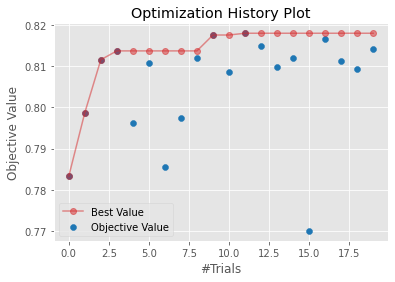

In [52]:
optuna.visualization.matplotlib.plot_optimization_history(lgb_study);

/var/folders/zv/m8v1knh55xzd5dkqt5p3cxcm0000gn/T/ipykernel_53356/3200258722.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(lgb_study);


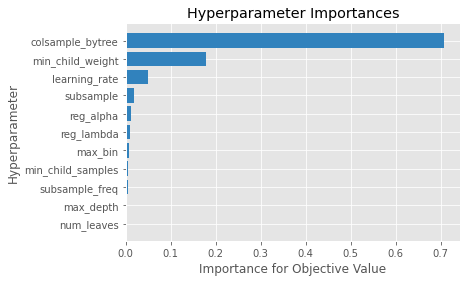

In [7]:
optuna.visualization.matplotlib.plot_param_importances(lgb_study);

/var/folders/zv/m8v1knh55xzd5dkqt5p3cxcm0000gn/T/ipykernel_53356/1653781200.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(lgb_study);


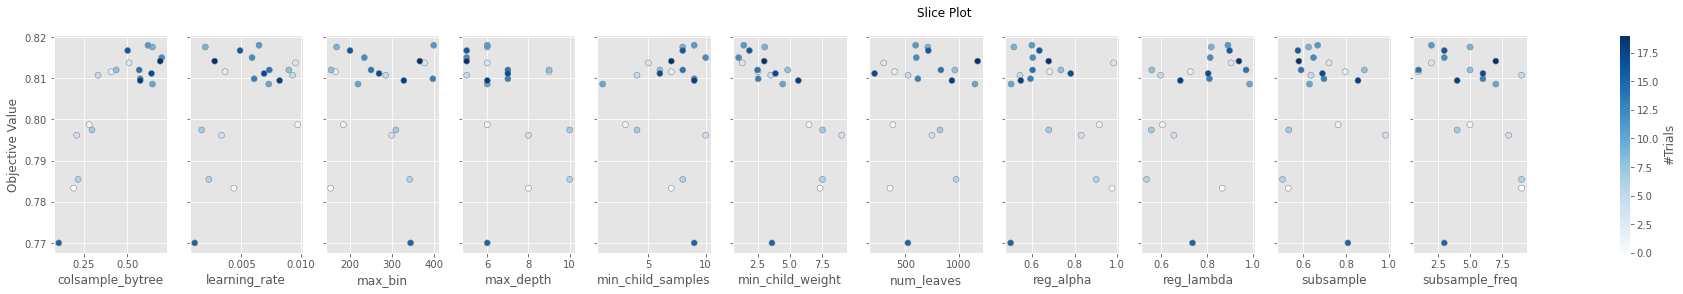

In [8]:
optuna.visualization.matplotlib.plot_slice(lgb_study);

### (2) Training

In [10]:
lgb_acc = []
lgb_pred = np.zeros((test_x.shape[0], 4))
seed = 42
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

for n, (train_idx, val_idx) in enumerate(skf.split(train_x, train_y)):
    print(f"{n+1} Fold Training.....")
    x_train, x_val = train_x.iloc[train_idx], train_x.iloc[val_idx]
    y_train, y_val = train_y.iloc[train_idx].values.ravel(), train_y.iloc[val_idx].values.ravel()
    
    lgbmodel = LGBMClassifier(**lgb_best_hyperparams)
    lgbmodel.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=30, verbose=None)

    val_pred = lgbmodel.predict_proba(x_val)
    val_cls = np.argmax(val_pred, axis=1)
    
    fold_lgb_acc = accuracy_score(y_val, val_cls)
    lgb_acc.append(fold_lgb_acc)
    
    print(f'fold{n+1} score: {fold_lgb_acc}')
    fold_pred = lgbmodel.predict_proba(test_x) / skf.n_splits
    lgb_pred += fold_pred

1 Fold Training.....
fold1 score: 0.8115631691648822
2 Fold Training.....
fold2 score: 0.8522483940042827
3 Fold Training.....
fold3 score: 0.828693790149893
4 Fold Training.....
fold4 score: 0.8094218415417559
5 Fold Training.....
fold5 score: 0.8436830835117773


In [11]:
np.mean(lgb_acc)

0.8291220556745182

## 4. CNN Modeling

### (1) HP Tuning

In [13]:
train_x = train.iloc[:, 1:-1]
test_x = test.iloc[:, 1:]

train_x = np.array(train_x).reshape(-1, 8, 4, 1)
test_x = np.array(test_x).reshape(-1, 8, 4, 1)

ohe = OneHotEncoder(sparse = False)
train_y = ohe.fit_transform(train[['target']])

In [14]:
def create_model(num_layer, mid_units, num_filters):
    
    model = Sequential()
    model.add(Conv2D(filters=num_filters[0], kernel_size=(2, 2),
                 activation="elu",
                 input_shape=(8, 4, 1)))
    model.add(BatchNormalization())
    #model.add(Dropout(dropout_rate[0]))
    for i in range(1,num_layer):
        model.add(Conv2D(filters=num_filters[i], kernel_size=(2, 2), padding="same", activation="elu"))
        model.add(BatchNormalization())
        #model.add(Dropout(dropout_rate[i+1]))
            
    model.add(GlobalAveragePooling2D())
    model.add(Dense(mid_units, activation='relu'))
    #model.add(Dropout(dropout_rate[-1]))
    model.add(Dense(4, activation='softmax'))
    
    return model

In [43]:
def cnn_objective(trial: Trial) -> float:
    
    #clear_session
    keras.backend.clear_session()
    
    #number of the convolution layer
    num_layer = trial.suggest_int("num_layer", 2, 3)
    
    #number of the unit
    mid_units = int(trial.suggest_discrete_uniform("mid_units", 30, 150, 10))
    
    #number of the each convolution layer filter
    num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]

    #Dropout
    #dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
    #dropout_rate = [int(trial.suggest_uniform("dropout_rate"+str(ii), 0.0, 0.5)) for ii in range(num_layer+1)]
    
        
    seed = 42
    kfold = StratifiedKFold(n_splits=5, random_state = seed, shuffle = True) # Cross-validation cv=5
    es = EarlyStopping(monitor="val_acc", patience=5, mode="max", verbose=0)
    cv = np.zeros((train_x.shape[0], 4))

    for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train.target)):

        x_train, y_train = train_x[train_idx], train_y[train_idx]
        x_val, y_val = train_x[val_idx], train_y[val_idx]
        
        mc = ModelCheckpoint(f"model/model_{n+1}.h5", save_best_only=True, monitor="val_acc", mode="max", verbose=0)
        
        model = create_model(num_layer, mid_units, num_filters)
        
        # Adam optimizer learning rate
        optimizer = Adam(learning_rate=trial.suggest_uniform("learning_rate", 0.0005, 0.005))
        model.compile(optimizer=optimizer,
                      loss="categorical_crossentropy",
                      metrics=["acc"])
        model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=32, 
                  callbacks=[es,mc], verbose=None)
        
        best = load_model(f"model/model_{n+1}.h5")
        
        cv[val_idx, :] = best.predict(x_val)
        
    print('multi_logloss:', log_loss(train_y, cv))
    print('accuracy_score:', accuracy_score(np.argmax(train_y, axis=1), np.argmax(cv, axis=1)))

    
    return accuracy_score(np.argmax(train_y, axis=1), np.argmax(cv, axis=1))

In [44]:
sampler = TPESampler(seed=42)
cnn_study = optuna.create_study(study_name="cnn_parameter_opt", direction="maximize", sampler=sampler)
cnn_study.optimize(cnn_objective, n_trials=20)

[I 2022-03-13 02:52:25,990] A new study created in memory with name: cnn_parameter_opt
[I 2022-03-13 02:54:23,282] Trial 0 finished with value: 0.8685224839400428 and parameters: {'num_layer': 2, 'mid_units': 150.0, 'num_filter_0': 192.0, 'num_filter_1': 160.0, 'learning_rate': 0.0012020838819909643}. Best is trial 0 with value: 0.8685224839400428.


multi_logloss: 0.3760324174698815
accuracy_score: 0.8685224839400428


[I 2022-03-13 02:56:19,885] Trial 1 finished with value: 0.8650963597430407 and parameters: {'num_layer': 2, 'mid_units': 30.0, 'num_filter_0': 224.0, 'num_filter_1': 160.0, 'learning_rate': 0.003686326600082205}. Best is trial 0 with value: 0.8685224839400428.


multi_logloss: 0.4004365354334175
accuracy_score: 0.8650963597430407


[I 2022-03-13 02:58:15,017] Trial 2 finished with value: 0.867237687366167 and parameters: {'num_layer': 2, 'mid_units': 150.0, 'num_filter_0': 224.0, 'num_filter_1': 64.0, 'learning_rate': 0.001318212352431953}. Best is trial 0 with value: 0.8685224839400428.


multi_logloss: 0.3713947446983017
accuracy_score: 0.867237687366167


[I 2022-03-13 03:00:15,993] Trial 3 finished with value: 0.8698072805139186 and parameters: {'num_layer': 2, 'mid_units': 60.0, 'num_filter_0': 144.0, 'num_filter_1': 112.0, 'learning_rate': 0.0018105311308911887}. Best is trial 3 with value: 0.8698072805139186.


multi_logloss: 0.38452974325051137
accuracy_score: 0.8698072805139186


[I 2022-03-13 03:17:15,099] Trial 4 finished with value: 0.860813704496788 and parameters: {'num_layer': 3, 'mid_units': 40.0, 'num_filter_0': 80.0, 'num_filter_1': 96.0, 'num_filter_2': 128.0, 'learning_rate': 0.004033291826268562}. Best is trial 3 with value: 0.8698072805139186.


multi_logloss: 0.4326137227264122
accuracy_score: 0.860813704496788


[I 2022-03-13 04:52:24,762] Trial 5 finished with value: 0.8749464668094219 and parameters: {'num_layer': 2, 'mid_units': 90.0, 'num_filter_0': 160.0, 'num_filter_1': 16.0, 'learning_rate': 0.003233951833556473}. Best is trial 5 with value: 0.8749464668094219.


multi_logloss: 0.37259975432556847
accuracy_score: 0.8749464668094219


[I 2022-03-13 13:03:11,441] Trial 6 finished with value: 0.8642398286937901 and parameters: {'num_layer': 2, 'mid_units': 30.0, 'num_filter_0': 256.0, 'num_filter_1': 256.0, 'learning_rate': 0.004137788066524076}. Best is trial 5 with value: 0.8749464668094219.


multi_logloss: 0.3934496958867761
accuracy_score: 0.8642398286937901


[I 2022-03-13 13:50:45,586] Trial 7 finished with value: 0.8706638115631692 and parameters: {'num_layer': 2, 'mid_units': 40.0, 'num_filter_0': 176.0, 'num_filter_1': 128.0, 'learning_rate': 0.0010491720568015048}. Best is trial 5 with value: 0.8749464668094219.


multi_logloss: 0.3753366897657568
accuracy_score: 0.8706638115631692


[I 2022-03-13 13:51:39,007] Trial 8 finished with value: 0.862526766595289 and parameters: {'num_layer': 2, 'mid_units': 30.0, 'num_filter_0': 240.0, 'num_filter_1': 80.0, 'learning_rate': 0.0034813502795929194}. Best is trial 5 with value: 0.8749464668094219.


multi_logloss: 0.4067045278104267
accuracy_score: 0.862526766595289


[I 2022-03-13 13:52:18,635] Trial 9 finished with value: 0.8732334047109208 and parameters: {'num_layer': 2, 'mid_units': 90.0, 'num_filter_0': 144.0, 'num_filter_1': 48.0, 'learning_rate': 0.004863130824940514}. Best is trial 5 with value: 0.8749464668094219.


multi_logloss: 0.3931581394206785
accuracy_score: 0.8732334047109208


[I 2022-03-13 13:53:02,229] Trial 10 finished with value: 0.8749464668094219 and parameters: {'num_layer': 3, 'mid_units': 120.0, 'num_filter_0': 16.0, 'num_filter_1': 16.0, 'num_filter_2': 256.0, 'learning_rate': 0.002608763616818648}. Best is trial 5 with value: 0.8749464668094219.


multi_logloss: 0.37703539683387033
accuracy_score: 0.8749464668094219


[I 2022-03-13 13:53:38,224] Trial 11 finished with value: 0.8689507494646681 and parameters: {'num_layer': 3, 'mid_units': 110.0, 'num_filter_0': 32.0, 'num_filter_1': 16.0, 'num_filter_2': 256.0, 'learning_rate': 0.002479771420377271}. Best is trial 5 with value: 0.8749464668094219.


multi_logloss: 0.3804888803554611
accuracy_score: 0.8689507494646681


[I 2022-03-13 13:54:22,410] Trial 12 finished with value: 0.8706638115631692 and parameters: {'num_layer': 3, 'mid_units': 110.0, 'num_filter_0': 80.0, 'num_filter_1': 16.0, 'num_filter_2': 256.0, 'learning_rate': 0.0026936415822376154}. Best is trial 5 with value: 0.8749464668094219.


multi_logloss: 0.3903185533978471
accuracy_score: 0.8706638115631692


[I 2022-03-13 13:55:39,144] Trial 13 finished with value: 0.8732334047109208 and parameters: {'num_layer': 3, 'mid_units': 90.0, 'num_filter_0': 96.0, 'num_filter_1': 224.0, 'num_filter_2': 64.0, 'learning_rate': 0.0021987242842348292}. Best is trial 5 with value: 0.8749464668094219.


multi_logloss: 0.37329921980105163
accuracy_score: 0.8732334047109208


[I 2022-03-13 13:56:20,817] Trial 14 finished with value: 0.8668094218415417 and parameters: {'num_layer': 3, 'mid_units': 120.0, 'num_filter_0': 16.0, 'num_filter_1': 32.0, 'num_filter_2': 176.0, 'learning_rate': 0.0031815312188221644}. Best is trial 5 with value: 0.8749464668094219.


multi_logloss: 0.39410663297809895
accuracy_score: 0.8668094218415417


[I 2022-03-13 13:57:34,546] Trial 15 finished with value: 0.8612419700214132 and parameters: {'num_layer': 3, 'mid_units': 70.0, 'num_filter_0': 48.0, 'num_filter_1': 64.0, 'num_filter_2': 176.0, 'learning_rate': 0.0030150691320635008}. Best is trial 5 with value: 0.8749464668094219.


multi_logloss: 0.4122516741255374
accuracy_score: 0.8612419700214132


[I 2022-03-13 13:59:06,051] Trial 16 finished with value: 0.8663811563169165 and parameters: {'num_layer': 3, 'mid_units': 130.0, 'num_filter_0': 112.0, 'num_filter_1': 192.0, 'num_filter_2': 32.0, 'learning_rate': 0.0019048449674378958}. Best is trial 5 with value: 0.8749464668094219.


multi_logloss: 0.39575200370693503
accuracy_score: 0.8663811563169165


[I 2022-03-13 14:01:15,907] Trial 17 finished with value: 0.8732334047109208 and parameters: {'num_layer': 3, 'mid_units': 80.0, 'num_filter_0': 192.0, 'num_filter_1': 48.0, 'num_filter_2': 208.0, 'learning_rate': 0.0006089804886221994}. Best is trial 5 with value: 0.8749464668094219.


multi_logloss: 0.3754496595157758
accuracy_score: 0.8732334047109208


[I 2022-03-13 14:02:22,205] Trial 18 finished with value: 0.8603854389721627 and parameters: {'num_layer': 2, 'mid_units': 130.0, 'num_filter_0': 128.0, 'num_filter_1': 96.0, 'learning_rate': 0.00479403366895009}. Best is trial 5 with value: 0.8749464668094219.


multi_logloss: 0.4169860079442086
accuracy_score: 0.8603854389721627


[I 2022-03-13 14:03:24,964] Trial 19 finished with value: 0.8710920770877945 and parameters: {'num_layer': 3, 'mid_units': 100.0, 'num_filter_0': 64.0, 'num_filter_1': 16.0, 'num_filter_2': 112.0, 'learning_rate': 0.0030313078566140375}. Best is trial 5 with value: 0.8749464668094219.


multi_logloss: 0.3814610116264181
accuracy_score: 0.8710920770877945


/var/folders/zv/m8v1knh55xzd5dkqt5p3cxcm0000gn/T/ipykernel_53356/1430751235.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(cnn_study);


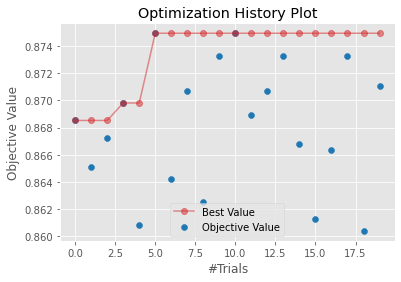

In [45]:
optuna.visualization.matplotlib.plot_optimization_history(cnn_study);

/var/folders/zv/m8v1knh55xzd5dkqt5p3cxcm0000gn/T/ipykernel_53356/3633289961.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(cnn_study);


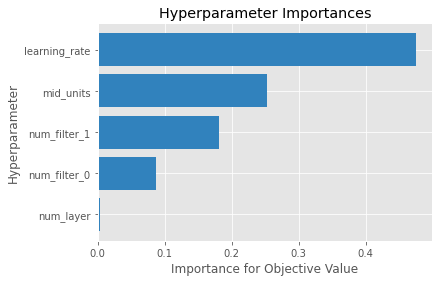

In [46]:
optuna.visualization.matplotlib.plot_param_importances(cnn_study);

/var/folders/zv/m8v1knh55xzd5dkqt5p3cxcm0000gn/T/ipykernel_53356/3328840784.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(cnn_study);


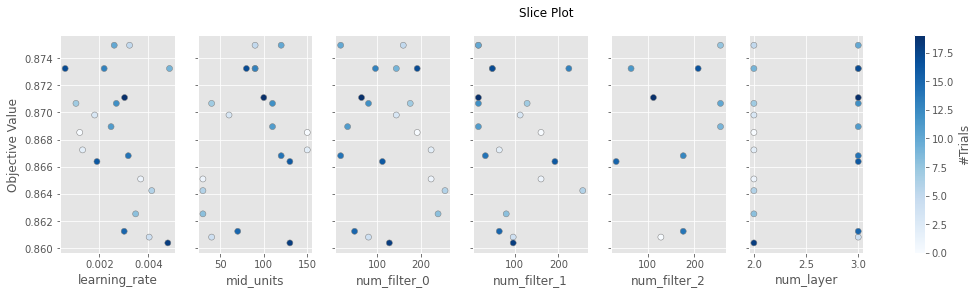

In [47]:
optuna.visualization.matplotlib.plot_slice(cnn_study);

In [48]:
cnn_acc = []
cnn_pred = np.zeros((test_x.shape[0], 4))
seed = 42
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
es = EarlyStopping(monitor="val_acc", patience=5, mode="max", verbose=0)

for i, (train_idx, val_idx) in enumerate(skf.split(train_x, train.target)):
    print(f"{i+1} Fold Training.....")
    x_train, y_train = train_x[train_idx], train_y[train_idx]
    x_val, y_val = train_x[val_idx], train_y[val_idx]
    
    cnn = create_model(cnn_study.best_params['num_layer'], cnn_study.best_params['mid_units'], 
                      [cnn_study.best_params[f'num_filter_{i}'] for i in range(cnn_study.best_params['num_layer'])])
    
    # ModelCheckpoint Fold마다 갱신
    mc = ModelCheckpoint(f"model_{i+1}.h5", save_best_only=True, monitor="val_acc", mode="max", verbose=0)
    
    # 모델 Complie
    optimizer = Adam(learning_rate=cnn_study.best_params['learning_rate'])
    cnn.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"])
    cnn.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=32, callbacks=[es,mc], verbose=0)
    
    # 최고 성능 기록 모델
    best = load_model(f"model_{i+1}.h5")
    
    val_pred = best.predict(x_val)
    
    val_cls = np.argmax(val_pred, axis=1)
    
    fold_cnn_acc = accuracy_score(np.argmax(y_val, axis=1), val_cls)
    cnn_acc.append(fold_cnn_acc)
    print(f"{i+1} Fold ACC of CNN = {fold_cnn_acc}\n")
    
    fold_pred = best.predict(test_x) / skf.n_splits
    cnn_pred += fold_pred

1 Fold Training.....
1 Fold ACC of CNN = 0.860813704496788

2 Fold Training.....
2 Fold ACC of CNN = 0.8907922912205567

3 Fold Training.....
3 Fold ACC of CNN = 0.8715203426124197

4 Fold Training.....
4 Fold ACC of CNN = 0.8715203426124197

5 Fold Training.....
5 Fold ACC of CNN = 0.8843683083511777



In [49]:
np.mean(cnn_acc)

0.8758029978586723

## 5. Submission

In [51]:
submission['target'] = np.argmax(
    lgb_pred * 0.2 +
    cnn_pred * 0.8,
    axis = 1)
submission.to_csv('submission/20220313-1.csv', index = False)
submission.target.value_counts()

1    2491
2    2395
0    2295
3    2162
Name: target, dtype: int64